In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq

# **SST**



Tx shape: (130, 8000)
ssq_freqs shape: (130, 8000)
ssq_slices shape: (130,)
Dtype of ssq_freqs: complex64


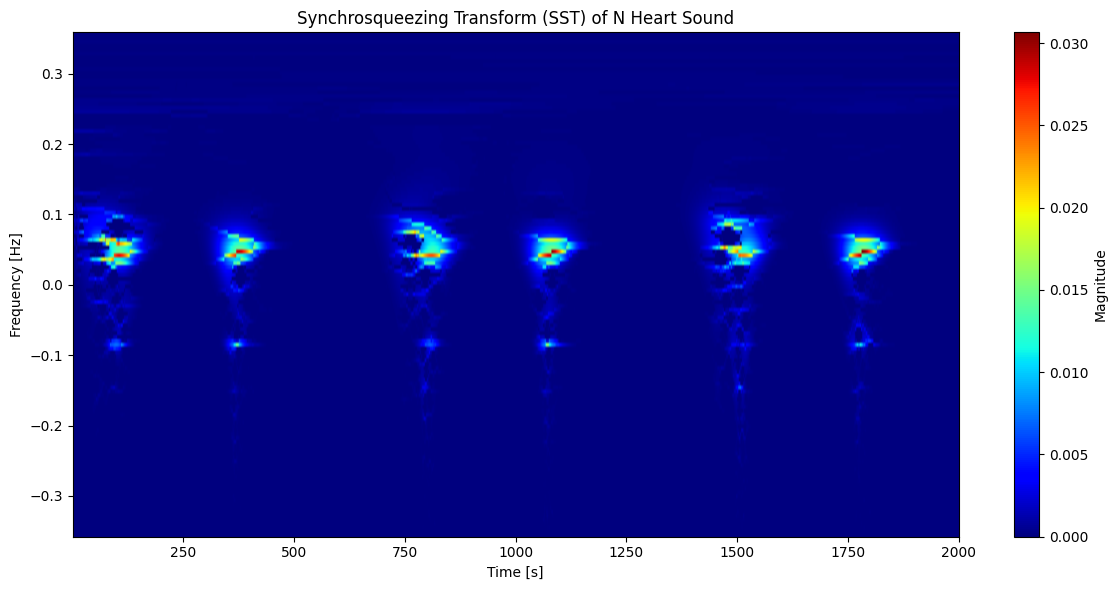

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from ssqueezepy import ssq_cwt # Removed imshow import

# === Step 1: Load and preprocess signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_002.wav'
signal, sr = sf.read(file_path)
signal = signal[:sr * 2]   # First 2 seconds
signal = signal[::2]       # Downsample to reduce memory
sr = sr // 2

# === Step 2: Apply SST with reduced resolution ===
Tx, ssq_freqs, ssq_slices, *_ = ssq_cwt(signal, fs=sr, nv=16)

# === Step 3: Get the magnitude of the SST result ===
Tx_abs = np.abs(Tx)

print("Tx shape:", Tx.shape)  # Should be (n_freqs, n_times)
print("ssq_freqs shape:", ssq_freqs.shape)
print("ssq_slices shape:", ssq_slices.shape)
print("Dtype of ssq_freqs:", ssq_freqs.dtype) # Print dtype for confirmation


# === Step 4: Plot with matplotlib.pyplot.imshow ===
plt.figure(figsize=(12, 6))

# Define extent using min/max of slices and the real part of min/max of freqs
extent = [ssq_slices.min(), ssq_slices.max(), ssq_freqs.real.min(), ssq_freqs.real.max()]

img = plt.imshow(Tx_abs, aspect='auto', origin='lower',
                 extent=extent,
                 cmap='jet')

plt.title("Synchrosqueezing Transform (SST) of N Heart Sound")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(img, label='Magnitude') # Pass the image object to colorbar
plt.tight_layout()
plt.show()

# **S-Transform**

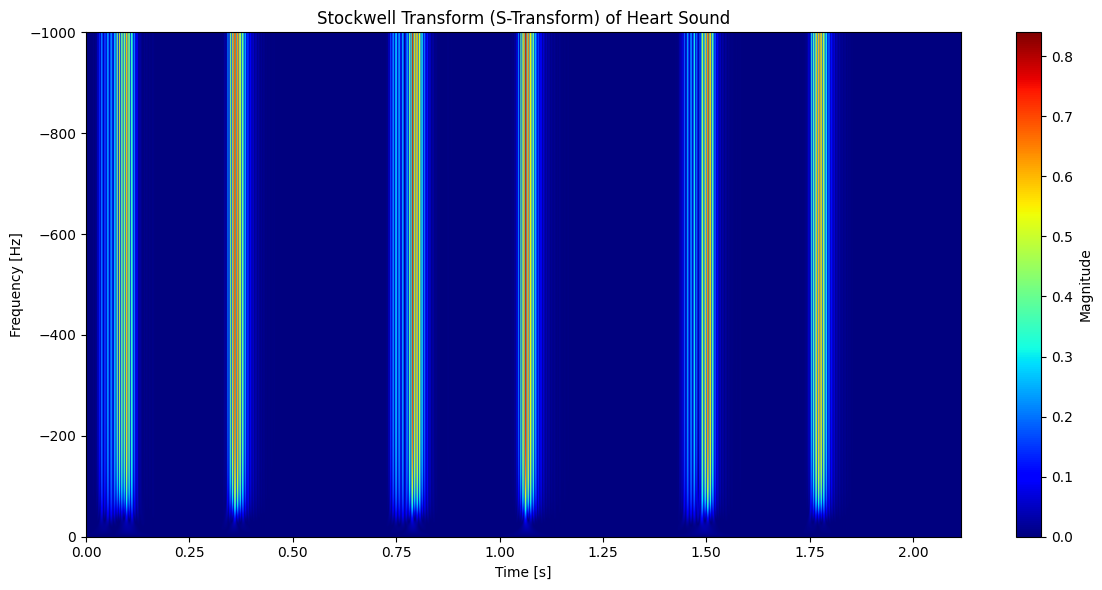

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft

# === Step 1: Load & downsample the heart sound ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_003.wav'
signal, sr = sf.read(file_path)
if signal.ndim > 1:
    signal = signal.mean(axis=1)

signal = signal[: sr * 3 : 4]  # 3 sec, downsample by 4
sr //= 4
N = len(signal)
t = np.arange(N) / sr

# === Step 2: Precompute ===
X = fft(signal)
freqs = np.fft.fftfreq(N, d=1/sr)
K = N // 2 + 1  # Only use positive frequencies
S = np.zeros((K, N), dtype=complex)

# === Step 3: Stockwell Transform over positive frequencies only ===
for k in range(K):
    f0 = freqs[k]
    if f0 == 0:
        S[k, :] = signal.mean()
    else:
        sigma_t = 1 / (2 * np.pi * abs(f0))
        omega = 2 * np.pi * np.fft.fftfreq(N, d=1/sr)  # NOW: length N
        G = np.exp(-0.5 * (sigma_t * omega) ** 2)      # Gaussian in freq domain
        S[k, :] = ifft(X * G)

# === Step 4: Plot the S-Transform magnitude ===
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(S), aspect='auto', origin='lower',
           extent=[0, t[-1], freqs[0], freqs[K - 1]], cmap='jet')
plt.title("Stockwell Transform (S-Transform) of Heart Sound")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()


# **SWT**

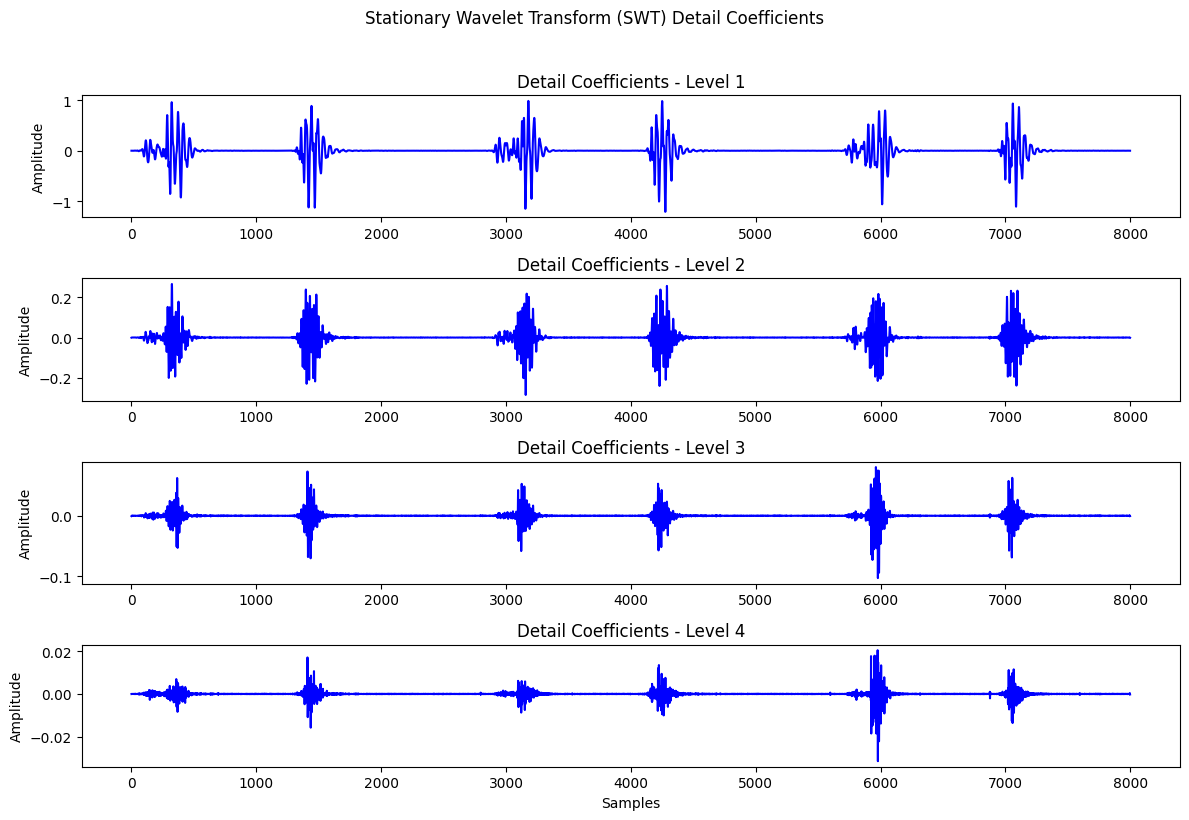

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pywt

# === Step 1: Load Heart Sound Signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_003.wav'
signal, sr = sf.read(file_path)

# === Step 2: Preprocess (first 2 seconds) ===
signal = signal[:sr * 2]
signal = signal[::2]  # Optional downsampling
sr = sr // 2

# === Step 3: Apply Stationary Wavelet Transform ===
wavelet = 'db4'         # Daubechies 4 is commonly used for heart signals
level = 4               # Number of decomposition levels
coeffs = pywt.swt(signal, wavelet, level=level)

# coeffs = [(cA_1, cD_1), ..., (cA_n, cD_n)]
# where cA = Approximation, cD = Detail coefficients at each level

# === Step 4: Plot SWT detail coefficients ===
plt.figure(figsize=(12, 8))
for i, (cA, cD) in enumerate(coeffs):
    plt.subplot(level, 1, i+1)
    plt.plot(cD, color='blue')
    plt.title(f'Detail Coefficients - Level {i+1}')
    plt.ylabel("Amplitude")
    plt.tight_layout()

plt.xlabel("Samples")
plt.suptitle("Stationary Wavelet Transform (SWT) Detail Coefficients", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
print("Shape of Tx:", Tx.shape)
print("Shape of freqs:", freqs.shape)
print("Shape of ts:", ts.shape)

Shape of Tx: (20849,)
Shape of freqs: (20849,)
Shape of ts: (20849,)


In [ ]:
print("Type of ssq_slices:", type(ssq_slices))
print("Shape of ssq_slices:", ssq_slices.shape)
print("Type of ssq_freqs:", type(ssq_freqs))
print("Shape of ssq_freqs:", ssq_freqs.shape)

Type of ssq_slices: <class 'numpy.ndarray'>
Shape of ssq_slices: (130,)
Type of ssq_freqs: <class 'numpy.ndarray'>
Shape of ssq_freqs: (130, 8000)


In [ ]:
print("Dtype of ssq_slices:", ssq_slices.dtype)
print("Dtype of ssq_freqs:", ssq_freqs.dtype)

Dtype of ssq_slices: float64
Dtype of ssq_freqs: complex64


# **Chirplet Transform**

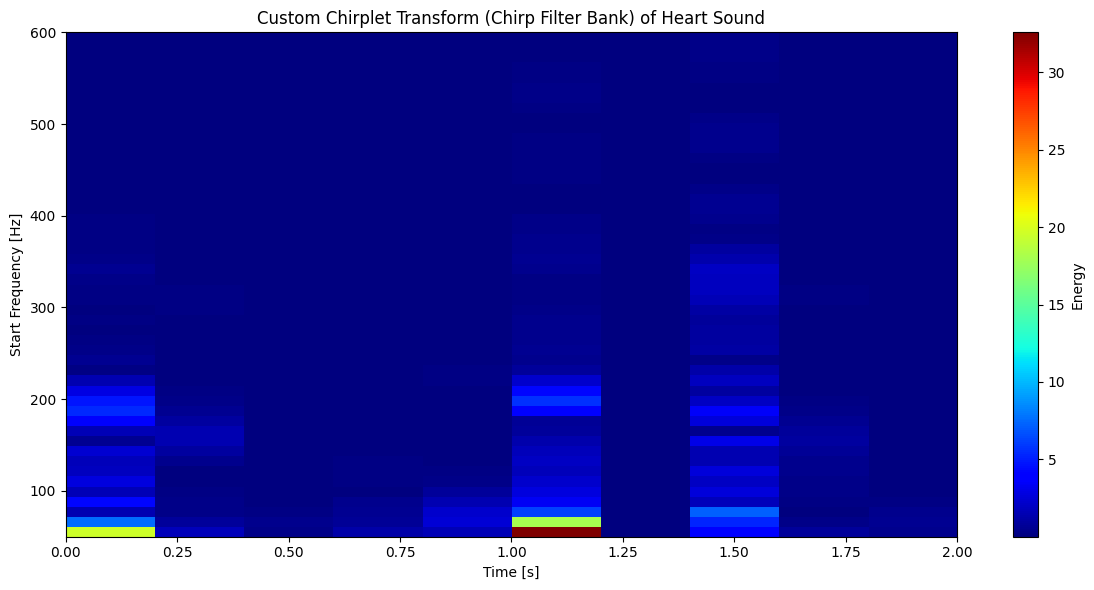

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import chirp, hilbert

# === Step 1: Load Heart Sound Signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_002.wav'
signal, sr = sf.read(file_path)
signal = signal[:sr * 2]        # First 2 seconds
signal = signal[::2]            # Optional downsample
sr = sr // 2

# === Step 2: Define parameters ===
window_length = int(0.2 * sr)   # 200 ms window
num_windows = len(signal) // window_length
t = np.linspace(0, window_length / sr, window_length)
f_start_range = np.linspace(50, 600, 50)  # Chirp start frequencies

# === Step 3: Chirplet Transform via matched filtering ===
chirplet_matrix = np.zeros((len(f_start_range), num_windows))

for i, f0 in enumerate(f_start_range):
    for j in range(num_windows):
        segment = signal[j * window_length : (j + 1) * window_length]
        if len(segment) < window_length:
            continue
        # Generate a linear chirp for this frequency
        template = chirp(t, f0=f0, f1=f0 + 100, t1=t[-1], method='linear') * np.hanning(window_length)
        analytic_template = hilbert(template)
        response = np.abs(np.dot(segment, np.conj(analytic_template)))
        chirplet_matrix[i, j] = response

# === Step 4: Plot the Chirplet Transform ===
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, len(signal) / sr, num_windows)
plt.imshow(chirplet_matrix, extent=[time_axis[0], time_axis[-1], f_start_range[0], f_start_range[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.title("Custom Chirplet Transform (Chirp Filter Bank) of Heart Sound")
plt.xlabel("Time [s]")
plt.ylabel("Start Frequency [Hz]")
plt.colorbar(label='Energy')
plt.tight_layout()
plt.show()


# **HHT**

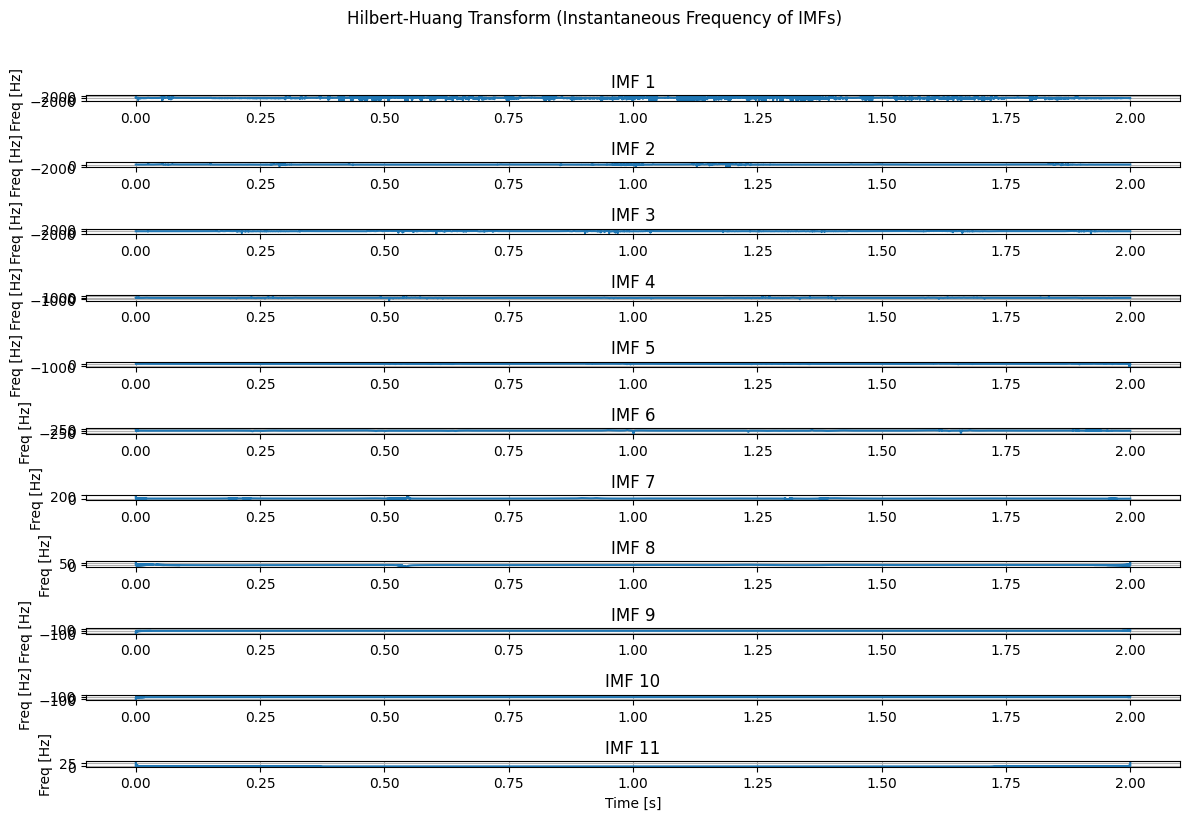

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from PyEMD import EMD
from scipy.signal import hilbert

# === Step 1: Load Heart Sound Signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_002.wav'
signal, sr = sf.read(file_path)

# === Step 2: Preprocess (first 2 seconds, optional downsample)
signal = signal[:sr * 2]
signal = signal[::2]  # Downsample
sr = sr // 2

# === Step 3: Apply EMD to get IMFs ===
emd = EMD()
IMFs = emd(signal)

# === Step 4: Apply Hilbert Transform to each IMF ===
time = np.arange(len(signal)) / sr
plt.figure(figsize=(12, 8))

for i, imf in enumerate(IMFs):
    # Compute analytic signal
    analytic_signal = hilbert(imf)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) * sr / (2.0 * np.pi)

    # Plot instantaneous frequency
    plt.subplot(len(IMFs), 1, i + 1)
    plt.plot(time[1:], instantaneous_frequency)
    plt.ylabel("Freq [Hz]")
    plt.title(f"IMF {i+1}")
    plt.grid(True)

plt.xlabel("Time [s]")
plt.suptitle("Hilbert-Huang Transform (Instantaneous Frequency of IMFs)", y=1.02)
plt.tight_layout()
plt.show()


# **WVD**

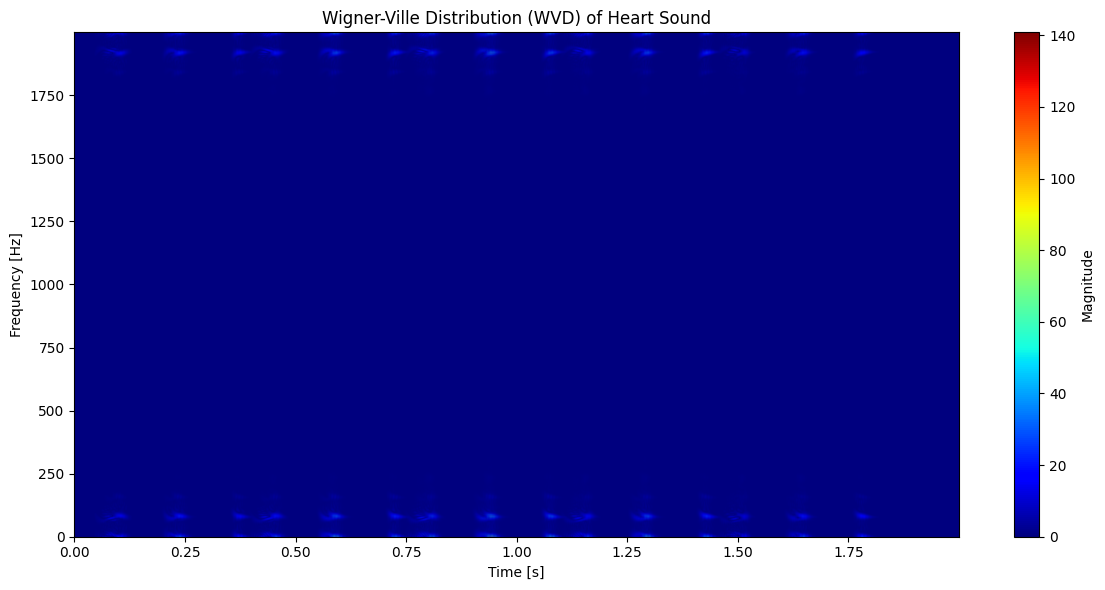

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tftb.processing import WignerVilleDistribution

# === Step 1: Load Heart Sound Signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_002.wav'
signal, sr = sf.read(file_path)

# === Step 2: Preprocess (First 2 seconds + optional downsample) ===
signal = signal[:sr * 2]
signal = signal[::2]
sr = sr // 2

# === Step 3: Apply Wigner-Ville Distribution ===
wvd = WignerVilleDistribution(signal)
tfr, t, f = wvd.run()

# === Step 4: Plot the WVD ===
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(tfr), extent=[t[0]/sr, t[-1]/sr, f[0], f[-1]*sr],
           aspect='auto', origin='lower', cmap='jet')
plt.title("Wigner-Ville Distribution (WVD) of Heart Sound")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()


# **Enhance Chirplet**

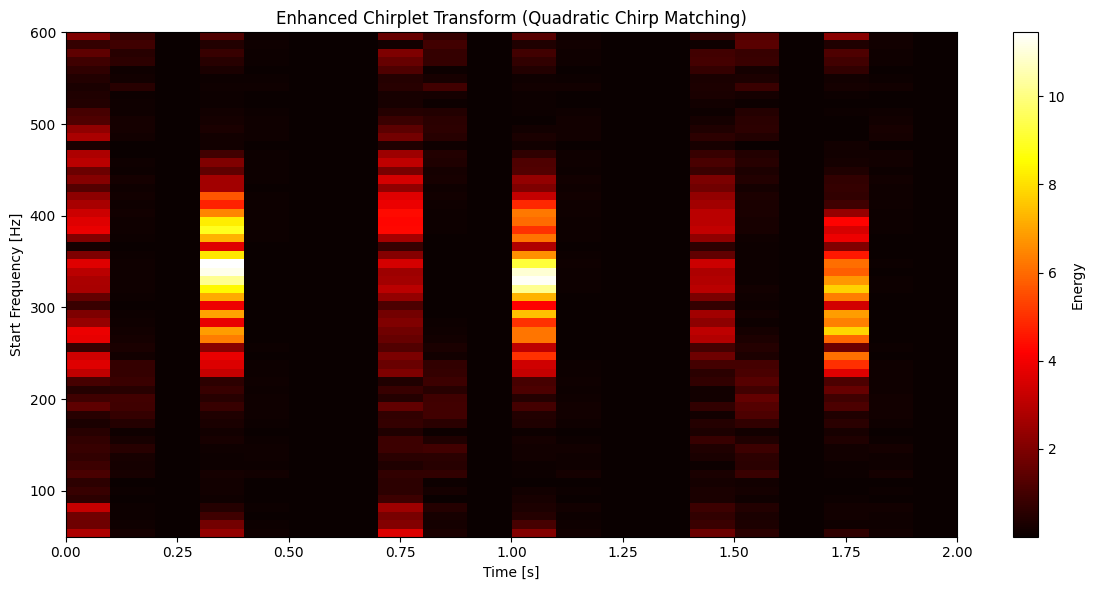

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import chirp, hilbert

# === Step 1: Load heart sound signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_003.wav'
signal, sr = sf.read(file_path)
signal = signal[:sr * 2]        # First 2 seconds
signal = signal[::2]            # Optional downsample
sr = sr // 2

# === Step 2: Parameters ===
win_len = int(0.1 * sr)         # 100 ms window
num_frames = len(signal) // win_len
f_start_range = np.linspace(50, 600, 60)  # Start frequencies for chirps
# === Step 3: Enhanced Chirplet Transform using Quadratic FM ===
enhanced_spec = np.zeros((len(f_start_range), num_frames))

for i, f0 in enumerate(f_start_range):
    for j in range(num_frames):
        segment = signal[j*win_len : (j+1)*win_len]
        if len(segment) < win_len:
            continue
        t = np.linspace(-0.5, 0.5, win_len)  # centered time vector
        # Quadratic frequency modulation: φ(t) = 2π(f0 t + α t²)
        alpha = 300  # modulation rate (adjustable)
        phase = 2 * np.pi * (f0 * t + alpha * t**2)
        chirp_wave = np.cos(phase) * np.hanning(win_len)
        analytic_chirp = hilbert(chirp_wave)
        enhanced_spec[i, j] = np.abs(np.dot(segment, np.conj(analytic_chirp)))

# === Step 4: Plot Enhanced Chirplet ===
plt.figure(figsize=(12, 6))
plt.imshow(enhanced_spec, extent=[time_axis[0], time_axis[-1], f_start_range[0], f_start_range[-1]],
           aspect='auto', origin='lower', cmap='hot')
plt.title("Enhanced Chirplet Transform (Quadratic Chirp Matching)")
plt.xlabel("Time [s]")
plt.ylabel("Start Frequency [Hz]")
plt.colorbar(label='Energy')
plt.tight_layout()
plt.show()


# **Enhance Log-Mal**

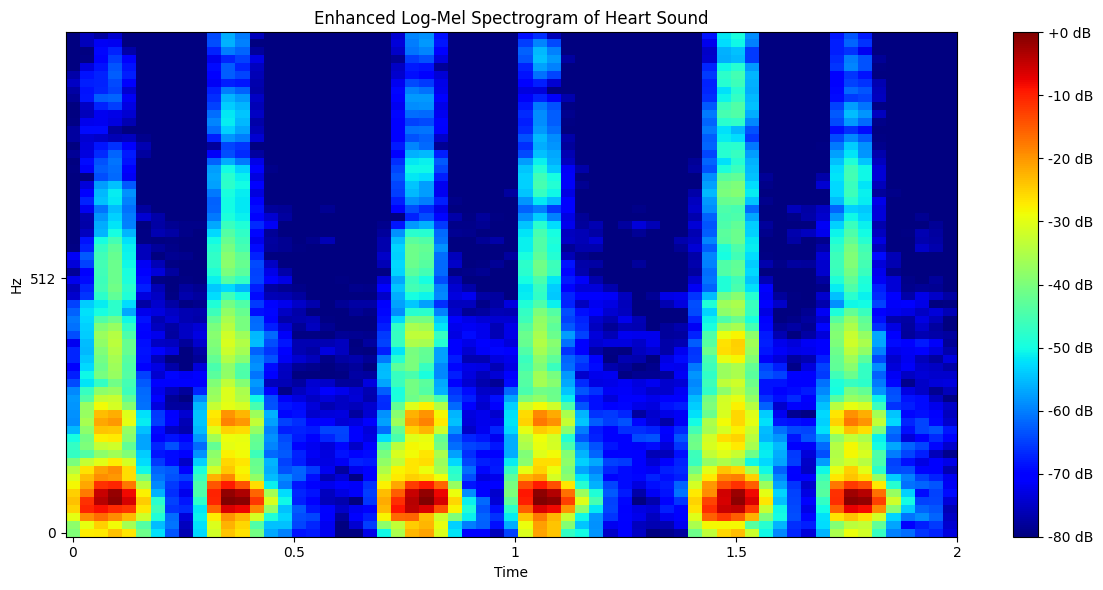

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display

# === Step 1: Load heart sound signal ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_003.wav'
signal, sr = sf.read(file_path)

# Optional: Convert stereo to mono if needed
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# === Step 2: Preprocess ===
signal = signal[:sr * 2]  # Use first 2 seconds
signal = librosa.util.normalize(signal)  # Normalize to [-1, 1]

# === Step 3: Compute Mel Spectrogram ===
n_fft = 1024
hop_length = 256
n_mels = 64

mel_spec = librosa.feature.melspectrogram(
    y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=1000
)

# === Step 4: Apply log compression (enhanced step) ===
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# === Step 5: Plot ===
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', fmax=1000, cmap='jet')
plt.title('Enhanced Log-Mel Spectrogram of Heart Sound')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


# **General Log-Mel**

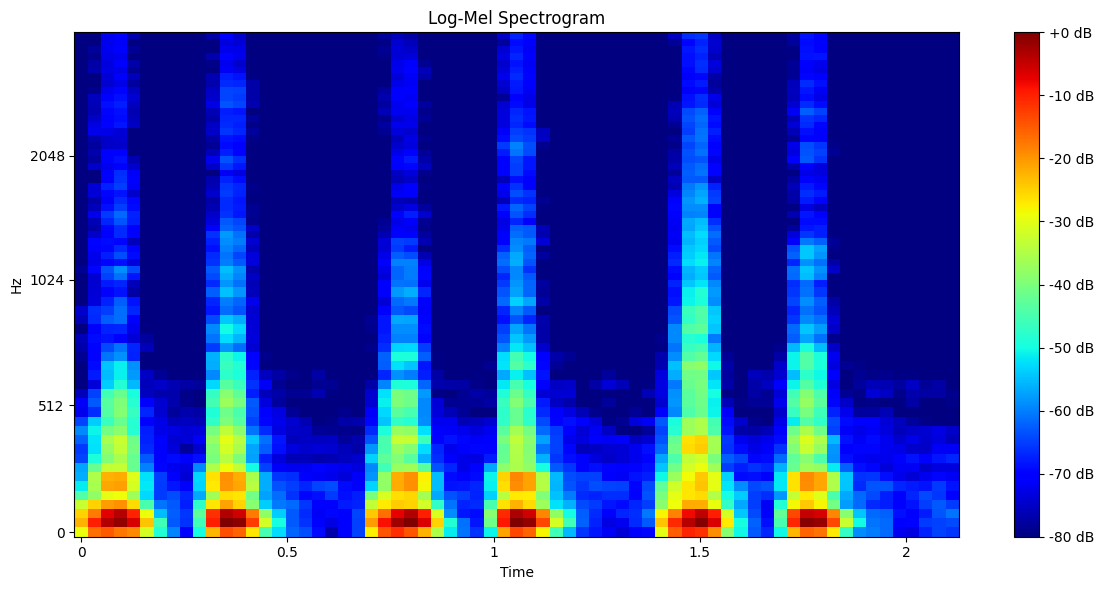

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# === Step 1: Load audio file ===
file_path = '/content/drive/MyDrive/signal_analysis/data/N/New_N_003.wav'  # Replace with your own path
y, sr = librosa.load(file_path, sr=None)  # Load audio, keep original sampling rate

# === Step 2: Parameters ===
n_fft = 1024         # Frame size for FFT
hop_length = 256     # Hop length (stride)
n_mels = 64          # Number of Mel bands
fmax = sr // 2       # Max frequency for Mel scale (Nyquist)

# === Step 3: Compute Mel Spectrogram ===
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                          hop_length=hop_length, n_mels=n_mels,
                                          fmax=fmax)

# === Step 4: Convert to Log-Mel Spectrogram (dB scale) ===
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# === Step 5: Display the Log-Mel Spectrogram ===
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', fmax=fmax, cmap='jet')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
